# 3: Data Input/Output

Computational neuroscience often involves a lot of data. In this lesson, you'll learn about:

- different kinds of data, how they are stored on disk
- how to read data from the disk into your program
- how to store data from your program to the disk

We'll consider three kinds of data:

- [time series](#Time-series-data)
- [point processes](#Point-processes)
- [structured records](#Structured-records)

# Time series data

Typically represented as an **array** of measurements: 

$$\mathbf{x} = \{x_0, x_1, \ldots, x_N\}$$

Can be **multichannel** if more than one measurement taken at a time. Each time point is now a **vector** ($\vec{x}$):

$$\mathbf{X} = \{\vec{x}_0, \vec{x}_1, \ldots, \vec{x}_N\}$$

Multichannel time series are represented as two-dimensional arrays. One dimension correponds to time and the other to the component of the measurement vector.

Note that the "channels" can be repeated **trials** rather than simultaneous measurements.

## Time series in Python

We use `numpy` arrays to store single- and multichannel time series in Python. Let's look at an example using some Gaussian white noise.

Gaussian noise is drawn from a normal distribution, and it's called white noise because it has equal power at all frequencies.

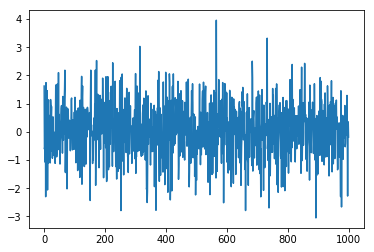

In [1]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import matplotlib.pyplot as plt   # plotting

np.random.seed(1)                 # set random seed
x = np.random.randn(1000)          # generate 100 random WN samples

plt.plot(x)

You can determine the number of elements in a 1D array using the `len()` function:

In [2]:
print("The number of points in x is:", len(x))

The number of points in x is: 1000


**Q**: Do you recall from the last exercise how to access subsets of a numpy array? In the code cell below, write an expression to evaluate the mean of the first 100 samples of `x`:

In [4]:
avg = np.mean(x[0:100])
print(avg)

0.0605828520757


Numpy (and Python in general) supports **negative indexing**, which means that negative indices are interpreted as referencing elements from the **end** of the array. The following expression gives us the mean of the last 100 elements.

In [9]:
np.mean(x[-100:1000])
# you can leave out the second index in the slice if it refers to the end of the array, so this is equivalent:
np.mean(x[-100:])

0.043330138016365184

## Multichannel time series

For multichannel data, the array has two dimensions. There is a (weak) convention that the first dimension of the array represents time. That means each column represents a separate channel.

Here is an example of a 3-channel array, again using Gaussian white noise. I've added some correlations between the channels to make things interesting.

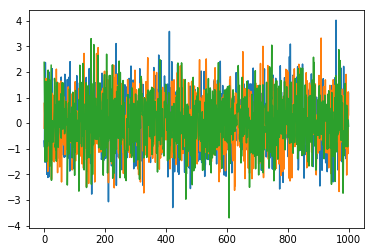

In [10]:
y = np.random.multivariate_normal(mean=[0, 0, 0], cov=[[1.0, 0.2, 0.0],[0.2, 1.0, 0.1], [0.0, 0.1, 1.0]], size=1000)
plt.plot(y);

Notice how the plot now has three different-colored traces? Matplotlib assumes that time is the first dimension when you give it an array to plot.

The size along each dimension of the array is called its **shape**. You can get the shape (and therefore the dimension of an array) using the `.shape` attribute:

In [11]:
print("The shape of y is:", y.shape)
# note that len returns the number of elements along the first dimension
print("The number of time points in y is:", len(y))
print("The total size of y is:", y.size)

The shape of y is: (1000, 3)
The number of time points in y is: 1000
The total size of y is: 3000


For multichannel data, we need two indices or slices to access values in the array.

In [12]:
# the first time point in the first channel. Note the comma.
y[0, 0]

-0.6975587622138143

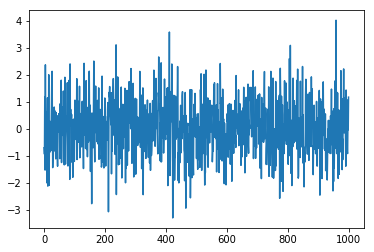

In [38]:
# use `:` to indicate all the values along one dimension. This gives all the values for the first channel
plt.plot(y[:, 0])

In [14]:
# to get all the channels at a time point:
print("y_0 =", y[0, :])
# you can leave out the trailing indices
print("y_0 =", y[0])

y_0 = [-0.69755876 -0.19664375  2.37084781]
y_0 = [-0.69755876 -0.19664375  2.37084781]


**Q**: Calculate and plot the mean of all three channels

0.492215100283


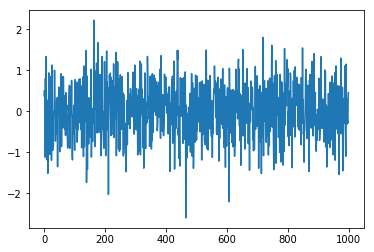

In [54]:
## Enter code here
i = 0
avg = []
while i < 1000:
    avg.append(np.mean(y[i]))
    i += 1

plt.plot(avg)

## I/O for Time Series

Presumably you'd like to look at more than just randomly generated noise. So how do you get data from a recording into your program?

Unfortunately, there is no agreed-upon standard for storing time series data, so you'll have to do some sleuthing.

There are three major kinds of storage formats: text, binary, and custom.

### Text

One way of storing numbers is how you would write them (i.e., as **text**). 

When reading a text file, the main thing you need to know is how the elements are separated. 

For single-channel data, usually each number goes on its own line. 

For multi-channel data, there will be multiple numbers per line, typically separated by white space (tabs and/or spaces) or by commas.

When you're storing data in text format, you also need to be mindful of the precision. 

#### Reading text files

One advantage of storing data as text is that it's human-readable. However, this isn't as much of an advantage as you might think. 

To see an example of an extracellular recording in text format, switch to the main Juptyer tab in your browser, navigate to the `data/io-examples` folder, and click on one of the files that ends in `.txt`

Numpy can easily load single- and multi-channel data from text files using the `loadtxt` command:

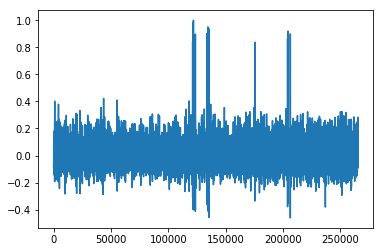

In [55]:
d = np.loadtxt("data/io-examples/st11_1_2_A8.txt")
plt.plot(d)

### Binary

Storing numbers as text is very inefficient. Let's see why.

In [56]:
## text is read into Python first as a string:
s = open("data/io-examples/st11_1_2_A8.txt", "r").readline().strip()
print("the number as text:", s)
print("size of the text (in bytes):", len(s))

## to use it as a number, python has to parse the text
f = float(s)
print("the number as a float:", f)
print("size of a float (in bytes):", d.dtype.itemsize)

the number as text: -6.308229813664596730e-02
size of the text (in bytes): 25
the number as a float: -0.06308229813664597
size of a float (in bytes): 8


#### Reading binary data

Not only does text-formatted data take up a lot more space, it also requires additional work for Python to translate into a numerical representation that it can do math on (i.e., floats and ints).

This inefficiency becomes a consideration for large datasets. Thus, we often want to store the data on disk in a binary format, i.e., the same format as it would be in memory.

A very powerful method for reading and writing binary data is to use a **memory map**. This essentially takes the contents of a binary file and treats it as an array.

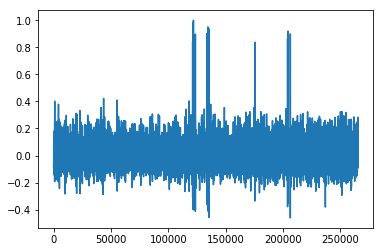

In [57]:
d = np.memmap("data/io-examples/st11_1_2_A8.dat", mode="r", dtype='d')
plt.plot(d)

## Structured formats

Text and raw binary formats both have shortcomings and tradeoffs.

A shortcoming they both have in common is that it can be difficult to store metadata.

Without metadata, it may be hard to know how to interpret the contents of the file.

Some critical metadata we need for time series include:

- sampling rate
- dimensions of the array
- ordering of the array (i.e., time first or last) and what's in each channel
- measurement units

**Q**: What other metadata do you think are important for time series data? Write a couple of ideas in the cell below.

Time and date of measurements, variable names

Structured data formats can be text- or binary-based.

Some formats are used widely and are well-documented, like [Javascript Object Notation](http://json.org) or [HDF5](https://support.hdfgroup.org/HDF5/). These formats are likely to have well-supported Python packages for I/O.
    
Other formats are more obscure or proprietary, like Axon Binary Format (ABF) or [Elan](http://elan.lyon.inserm.fr/). It may be difficult to find Python support to read these files, though the situation is improving thanks to projects like [Neo IO](https://neo.readthedocs.io/).

# Point processes

Typically represented as an ordered sequence of times in some interval from 0 to $T$:

$$\{0 \leq t_0 < t_1 < \ldots < t_N \leq T\}$$

In contrast to time series, there is not a fixed relationship between the number of events and the duration of the analysis interval.

## Point process data in Python

Point processes are also typically stored in `numpy` arrays, but the elements of the array are event times, not measurements.

Because point processes vary in the number of events, multi-channel point-processes are represented by **lists of arrays**, not by 2D arrays.

Let's look at some examples:

In [58]:
from tools import pprox
resp = pprox.load("st11_1_2_1")
resp_A8 = pprox.select_stimulus(resp, "A8")

The variable `resp_A8` points to a Python **list**. Lists are like arrays, but they can store heterogeneous data types. The syntax for accessing elements and slices is the same.

**Q:** Using what you know from previous exercises, complete the following code cell to print out some information about the data: 

In [60]:
print("The number of trials is:", len(resp_A8))
print("The number of events in trial 0 is:", len(resp_A8[0]))
print("The time of the first event in trial 2 is:", resp_A8[2][0])

The number of trials is: 5
The number of events in trial 0 is: 18
The time of the first event in trial 2 is: 4.06254980469


## I/O for Point Processes

Just as there is no agreed-upon standard for storing time series data, there is also no standard format for point-process data.

Because point process data tend to be smaller than time series, text formats are more common than binary.

A very simple text format is to put each trial (or channel) on a separate line and separate the events on each line with a space. Take a look at `data/io-examples/st_11_2_1_A8.txt` for an example.

The [PySpike](http://mariomulansky.github.io/PySpike/) library has a function for loading data from such files, but we're going to write our own so that we can learn a bit about basic I/O in Python and looping.

In [61]:
# create a list where we will store our trials
trials = []
# open the file for reading
fp = open("data/io-examples/st11_1_2_1_A8.txt", mode="r")
# loop through the lines of the file with a for statement
for line in fp:
    # read the line into an array
    arr = np.fromstring(line, sep=" ")
    # append the array to our list
    trials.append(arr)

If you learned how to program in Java or C or another low-level programming language, take a moment to appreciate how simple this task is in Python.

### Checking our work

**Q:** The `trials` list we created in the last code cell should be the same as `resp_A8`. In the cell below, write **three assert** statements to check that this is true. I've provided you with one to get started.

In [75]:
assert len(trials) == len(resp_A8), "The number of trials is not the same"
assert len(trials[0]) == len(resp_A8[0]), "The first element of trials and resp_A8 is not the same"
assert len(trials[2]) == len(resp_A8[2]), "The third element of the second trial is not the same"

### Point process metadata

As with time series data, it's important to keep track of metadata. Here are some important metadata that need to be associated with point process files:

- type of event (e.g., spike, behavioral action, stimulus start/stop)
- number of channels
- unit scaling (e.g., milliseconds or seconds?)
- start time
- other experimental variables

## Structured Records

In both point process and time series data, the elements of the arrays have been **homogeneous** (i.e., all the same type). What if that's not the case?

The third (and final) kind of data we'll consider today consists of **records**. Each record in turn comprises **fields**, which may have different types.

This kind of data is also called **tabular data**. If you're coming from the R world, you might think of this kind of data as a `data.frame`.

It's common to encounter structured records when you have independent observations; for example, from different neurons or animals or populations. The fields in each record might include:

- a unique identifier for the observation
- group identifiers (e.g., cell, animal, population)
- independent variables (e.g., sex, treatment, age)
- dependent variable(s)

## Structured records in Python

Python used to lag pretty badly behind R for handling this kind of data, but we now have [pandas](http://pandas.pydata.org/), which is beginning to approach `numpy` in popularity and maturity.

As with numpy, there is a convention for importing pandas: 

```python
import pandas as pd
```

For a detailed introduction to pandas, take a look at [Chapter 3](https://jakevdp.github.io/PythonDataScienceHandbook/03.00-introduction-to-pandas.html) of the Python Data Science Handbook.

There are two main concepts to understand in using pandas: `Series` and `DataFrames`.

A `Series` is essentially a column of a table. Like a numpy array, all the elements of a series are the same type. Unlike a numpy array, the indices of a `Series` do not have to be sequential integers, but can be any label you like.

For example, here's a `Series` that might represent the ages of several subjects:

In [63]:
import pandas as pd
ages = pd.Series([391, 442, 183], index=['st11', 'st22', 'st231'])
ages

st11     391
st22     442
st231    183
dtype: int64

You can access the elements of a `Series` using the standard Python bracket syntax:

In [64]:
ages['st11']

391

A `DataFrame` is a collection of `Series`, i.e. a table of columns. Here's how we might represent the ages and sexes of a set of subjects:

In [65]:
sex = pd.Series(['M', 'F', 'M'], index=['st11', 'st22', 'st231'])
subjects = pd.DataFrame({'age': ages, 'sex': sex})
subjects

,age,sex
st11,391,M
st22,442,F
st231,183,M


Notice how we now have a table, which Jupyter renders nicely for us with the row and column indices are indicated in bold.

The bracket syntax for `DataFrames` accesses **columns**. It's important to remember that this is different from numpy arrays, where a single index gives you a row.

In [66]:
subjects['age']

st11     391
st22     442
st231    183
Name: age, dtype: int64

To index by row and column, you have to use the `loc` attribute:

In [67]:
subjects.loc['st11', 'age']

391

Equivalently, you can use `iloc` and the numerical indices:

In [68]:
subjects.iloc[0, 0]

391

## I/O for Structured Records

Structured record data is usually stored on disk in text-based formats. This is because human readability is often quite important. There are two very common formats:

- In comma-separated-value files, each record is on a separate line, and fields are separated by commas.
- In whitespace-delimiated-value files, each record is on a separate line, and fields are separated by white space (tabs or spaces)

In both kinds of files, it's common that the first line of the file is a header giving the name for each column.

Take a look at `data/stimuli/motifs.csv` for an example of a comma-delimited file.

One really good reason to use pandas is that it provides some nice I/O functions for these kinds of files. It's trivial to load tabular data into Python:

In [69]:
df = pd.read_csv("data/stimuli/motifs.csv")
df

,song,motif,variant,start,stop
0,A0,aa,1,18,1690
1,A0,ab,1,1754,2930
2,A0,ac,1,2930,3609
3,A0,ac,2,3609,4442
4,A0,ad,1,4442,5488
5,A0,ae,1,5490,6267
6,A0,ae,2,6267,7224
7,A0,af,1,7250,8034
8,A0,af,2,8053,8806
9,A0,af,3,8832,9585


You can tell pandas that certain columns should be used as indices.

This allows you to select rows using the `loc` syntax.

In [70]:
motifs = pd.read_csv("data/stimuli/motifs.csv", index_col="song")
motifs.loc['A8']

,motif,variant,start,stop
song,,,,
A8,bg,1,17,666
A8,bh,1,689,1375
A8,bg,2,1399,2224
A8,bh,2,2264,3051
A8,bh,3,3079,3993
A8,bh,4,4009,4643
A8,bi,1,4650,5204
A8,bh,5,5206,5870
A8,bi,2,5870,6720


### A slightly harder problem

Write code in the cell below to compute the following:

- the number of different songs
- the number of motifs for each song
- the average motif duration in each song

In [ ]:
print("hi")